In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

In [2]:
empY = pd.read_csv('cj_empY.csv')
empY

,scd,gender,age_grp,weekday,total_qty,total_amt,event_product,amt/qty,prime_yn,ctg_0,ctg_1,ctg_2,ctg_3
0,20230101963226,1,3,0,6,39.433806,2,7.609629,0,1,0,1,0
1,20230101963235,0,4,0,2,19.234566,2,9.617283,1,1,1,0,0
2,20230101963247,1,3,0,6,45.516855,0,8.070212,1,1,1,0,1
3,20230101963251,0,3,0,2,10.845621,0,5.422811,1,0,0,0,1
4,20230101963253,1,2,0,6,47.014742,0,8.445540,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4708,20230131216567,0,5,1,6,27.652922,1,5.733350,1,1,0,0,0
4709,20230131216610,1,3,1,12,81.994470,6,8.342528,1,1,1,0,1
4710,20230131216674,1,4,1,4,37.317843,0,9.329461,0,0,1,0,0
4711,20230131216734,1,5,1,3,29.500314,3,9.833438,1,1,0,1,0


In [3]:
empY.set_index('scd',inplace=True)
empY

,gender,age_grp,weekday,total_qty,total_amt,event_product,amt/qty,prime_yn,ctg_0,ctg_1,ctg_2,ctg_3
scd,,,,,,,,,,,,
20230101963226,1,3,0,6,39.433806,2,7.609629,0,1,0,1,0
20230101963235,0,4,0,2,19.234566,2,9.617283,1,1,1,0,0
20230101963247,1,3,0,6,45.516855,0,8.070212,1,1,1,0,1
20230101963251,0,3,0,2,10.845621,0,5.422811,1,0,0,0,1
20230101963253,1,2,0,6,47.014742,0,8.445540,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20230131216567,0,5,1,6,27.652922,1,5.733350,1,1,0,0,0
20230131216610,1,3,1,12,81.994470,6,8.342528,1,1,1,0,1
20230131216674,1,4,1,4,37.317843,0,9.329461,0,0,1,0,0


<AxesSubplot:>

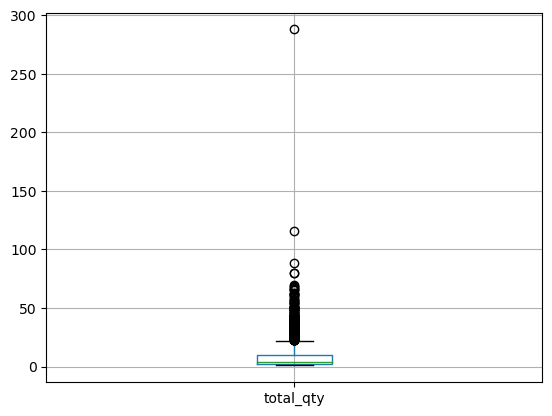

In [4]:
empY.boxplot(column='total_qty')

In [5]:
empY.boxplot(column='total_amt')

<AxesSubplot:>

In [6]:
empY.boxplot(column='amt/qty')

<AxesSubplot:>

#### empY_new

In [7]:
# 최대값 제거
empY_new = empY[empY['total_amt'] != empY['total_amt'].max()]
empY_new = empY[empY['total_qty'] != empY['total_qty'].max()]

#### xgBoost

In [37]:
# X, y 나누기
X = empY[['gender','age_grp','total_qty', 'total_amt',
          'event_product', 'amt/qty', 'ctg_0','ctg_1', 'ctg_2', 'ctg_3']]
y = empY['prime_yn']

In [38]:
# train, valid 데이터셋 나누기
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(3534, 10) (1179, 10) (3534,) (1179,)


In [40]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

xgb_model = XGBClassifier(n_estimators=1000)

# 후보 파라미터 선정
params = {'max_depth':[4,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb_model, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_valid, y_valid)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-auc:0.54754
[1]	validation_0-auc:0.57311
[2]	validation_0-auc:0.62194
[3]	validation_0-auc:0.62579
[4]	validation_0-auc:0.62388
[5]	validation_0-auc:0.62784
[6]	validation_0-auc:0.63612
[7]	validation_0-auc:0.64138
[8]	validation_0-auc:0.64586
[9]	validation_0-auc:0.64487
[10]	validation_0-auc:0.64309
[11]	validation_0-auc:0.64110
[12]	validation_0-auc:0.64488
[13]	validation_0-auc:0.64798
[14]	validation_0-auc:0.64790
[15]	validation_0-auc:0.64449
[16]	validation_0-auc:0.64453
[17]	validation_0-auc:0.64595
[18]	validation_0-auc:0.64705
[19]	validation_0-auc:0.64667
[20]	validation_0-auc:0.64435
[21]	validation_0-auc:0.64582
[22]	validation_0-auc:0.64067
[23]	validation_0-auc:0.64107
[24]	validation_0-auc:0.64166
[25]	validation_0-auc:0.64085
[26]	validation_0-auc:0.64253
[27]	validation_0-auc:0.64232
[28]	validation_0-auc:0.64272
[29]	validation_0-auc:0.64341
[30]	validation_0-auc:0.64427
[31]	validation_0-auc:0.64087
[32]	validation_0-auc:0.64483
[33]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-auc:0.53249
[2]	validation_0-auc:0.59780
[3]	validation_0-auc:0.60990
[4]	validation_0-auc:0.60846
[5]	validation_0-auc:0.60761
[6]	validation_0-auc:0.61525
[7]	validation_0-auc:0.63119
[8]	validation_0-auc:0.63664
[9]	validation_0-auc:0.64072
[10]	validation_0-auc:0.63677
[11]	validation_0-auc:0.64197
[12]	validation_0-auc:0.64152
[13]	validation_0-auc:0.64223
[14]	validation_0-auc:0.64247
[15]	validation_0-auc:0.64287
[16]	validation_0-auc:0.64398
[17]	validation_0-auc:0.64909
[18]	validation_0-auc:0.64976
[19]	validation_0-auc:0.64547
[20]	validation_0-auc:0.64391
[21]	validation_0-auc:0.64814
[22]	validation_0-auc:0.64908
[23]	validation_0-auc:0.64788
[24]	validation_0-auc:0.64500
[25]	validation_0-auc:0.64490
[26]	validation_0-auc:0.64519
[27]	validation_0-auc:0.64971
[28]	validation_0-auc:0.65004
[29]	validation_0-auc:0.65059
[30]	validation_0-auc:0.64996
[31]	validation_0-auc:0.65045
[32]	validation_0-auc:0.65067
[33]	validation_0-auc:0.65379
[34]	validation_0-a

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

[1]	validation_0-auc:0.56441
[2]	validation_0-auc:0.61866
[3]	validation_0-auc:0.62060
[4]	validation_0-auc:0.61808
[5]	validation_0-auc:0.61970
[6]	validation_0-auc:0.62778
[7]	validation_0-auc:0.62855
[8]	validation_0-auc:0.63223
[9]	validation_0-auc:0.62933
[10]	validation_0-auc:0.63529
[11]	validation_0-auc:0.63275
[12]	validation_0-auc:0.63586
[13]	validation_0-auc:0.63453
[14]	validation_0-auc:0.63166
[15]	validation_0-auc:0.63235
[16]	validation_0-auc:0.63499
[17]	validation_0-auc:0.63942
[18]	validation_0-auc:0.63870
[19]	validation_0-auc:0.64063
[20]	validation_0-auc:0.63990
[21]	validation_0-auc:0.64027
[22]	validation_0-auc:0.64009
[23]	validation_0-auc:0.64109
[24]	validation_0-auc:0.64246
[25]	validation_0-auc:0.64464
[26]	validation_0-auc:0.64349
[27]	validation_0-auc:0.64132
[28]	validation_0-auc:0.64204
[29]	validation_0-auc:0.64700
[30]	validation_0-auc:0.64663
[31]	validation_0-auc:0.64656
[32]	validation_0-auc:0.64554
[33]	validation_0-auc:0.64405
[34]	validation_0-a

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.62799
[39]	validation_0-auc:0.62842
[40]	validation_0-auc:0.62957
[41]	validation_0-auc:0.63041
[42]	validation_0-auc:0.62996
[0]	validation_0-auc:0.53599
[1]	validation_0-auc:0.56390
[2]	validation_0-auc:0.60061
[3]	validation_0-auc:0.61262
[4]	validation_0-auc:0.60689
[5]	validation_0-auc:0.60821
[6]	validation_0-auc:0.61160
[7]	validation_0-auc:0.61002
[8]	validation_0-auc:0.61706
[9]	validation_0-auc:0.61734
[10]	validation_0-auc:0.61903
[11]	validation_0-auc:0.62287
[12]	validation_0-auc:0.62645
[13]	validation_0-auc:0.62657
[14]	validation_0-auc:0.62650
[15]	validation_0-auc:0.62741
[16]	validation_0-auc:0.62869
[17]	validation_0-auc:0.63148
[18]	validation_0-auc:0.63293
[19]	validation_0-auc:0.62971
[20]	validation_0-auc:0.63384
[21]	validation_0-auc:0.63518
[22]	validation_0-auc:0.63858
[23]	validation_0-auc:0.63824
[24]	validation_0-auc:0.63925
[25]	validation_0-auc:0.63920
[26]	validation_0-auc:0.63903
[27]	validation_0-auc:0.63931
[28]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-auc:0.64375
[42]	validation_0-auc:0.64878
[43]	validation_0-auc:0.64955
[44]	validation_0-auc:0.65232
[45]	validation_0-auc:0.65105
[46]	validation_0-auc:0.65000
[47]	validation_0-auc:0.65097
[48]	validation_0-auc:0.65122
[49]	validation_0-auc:0.65032
[50]	validation_0-auc:0.64906
[51]	validation_0-auc:0.64881
[52]	validation_0-auc:0.64874
[53]	validation_0-auc:0.64834
[54]	validation_0-auc:0.64825
[55]	validation_0-auc:0.64846
[56]	validation_0-auc:0.64892
[57]	validation_0-auc:0.64863
[58]	validation_0-auc:0.64784
[59]	validation_0-auc:0.64854
[60]	validation_0-auc:0.64907
[61]	validation_0-auc:0.64994
[62]	validation_0-auc:0.64975
[63]	validation_0-auc:0.64982
[64]	validation_0-auc:0.65257
[65]	validation_0-auc:0.65130
[66]	validation_0-auc:0.64988
[67]	validation_0-auc:0.65067
[68]	validation_0-auc:0.64906
[69]	validation_0-auc:0.64770
[70]	validation_0-auc:0.65179
[71]	validation_0-auc:0.65183
[72]	validation_0-auc:0.65110
[73]	validation_0-auc:0.64870
[74]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.64721
[29]	validation_0-auc:0.64776
[30]	validation_0-auc:0.64742
[31]	validation_0-auc:0.64290
[32]	validation_0-auc:0.64178
[33]	validation_0-auc:0.64137
[34]	validation_0-auc:0.63738
[35]	validation_0-auc:0.63895
[36]	validation_0-auc:0.63916
[37]	validation_0-auc:0.63940
[38]	validation_0-auc:0.63969
[39]	validation_0-auc:0.63940
[40]	validation_0-auc:0.64031
[41]	validation_0-auc:0.64129
[42]	validation_0-auc:0.64174
[43]	validation_0-auc:0.64218
[44]	validation_0-auc:0.64200
[45]	validation_0-auc:0.64215
[0]	validation_0-auc:0.55627
[1]	validation_0-auc:0.56878
[2]	validation_0-auc:0.59773
[3]	validation_0-auc:0.61534
[4]	validation_0-auc:0.61616
[5]	validation_0-auc:0.61960
[6]	validation_0-auc:0.62685
[7]	validation_0-auc:0.63346
[8]	validation_0-auc:0.63768
[9]	validation_0-auc:0.63783
[10]	validation_0-auc:0.63612
[11]	validation_0-auc:0.64384
[12]	validation_0-auc:0.64680
[13]	validation_0-auc:0.65076
[14]	validation_0-auc:0.65097
[15]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.65334
[30]	validation_0-auc:0.65258
[31]	validation_0-auc:0.65463
[32]	validation_0-auc:0.65636
[33]	validation_0-auc:0.65919
[34]	validation_0-auc:0.66001
[35]	validation_0-auc:0.66032
[36]	validation_0-auc:0.65982
[37]	validation_0-auc:0.65874
[38]	validation_0-auc:0.65781
[39]	validation_0-auc:0.65916
[40]	validation_0-auc:0.65878
[41]	validation_0-auc:0.65774
[42]	validation_0-auc:0.65866
[43]	validation_0-auc:0.65648
[44]	validation_0-auc:0.65624
[45]	validation_0-auc:0.65624
[46]	validation_0-auc:0.65715
[47]	validation_0-auc:0.65623
[48]	validation_0-auc:0.65558
[49]	validation_0-auc:0.65482
[50]	validation_0-auc:0.65472
[51]	validation_0-auc:0.65442
[52]	validation_0-auc:0.65296
[53]	validation_0-auc:0.65203
[54]	validation_0-auc:0.65172
[55]	validation_0-auc:0.65227
[56]	validation_0-auc:0.65173
[57]	validation_0-auc:0.65132
[58]	validation_0-auc:0.65009
[59]	validation_0-auc:0.64994
[60]	validation_0-auc:0.65003
[61]	validation_0-auc:0.65096
[62]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.65558
[29]	validation_0-auc:0.65424
[30]	validation_0-auc:0.65488
[31]	validation_0-auc:0.65595
[32]	validation_0-auc:0.65537
[33]	validation_0-auc:0.65242
[34]	validation_0-auc:0.65261
[35]	validation_0-auc:0.64860
[36]	validation_0-auc:0.64592
[37]	validation_0-auc:0.64635
[38]	validation_0-auc:0.64450
[39]	validation_0-auc:0.64606
[40]	validation_0-auc:0.64987
[41]	validation_0-auc:0.64978
[42]	validation_0-auc:0.65011
[43]	validation_0-auc:0.65152
[44]	validation_0-auc:0.65149
[45]	validation_0-auc:0.65164
[46]	validation_0-auc:0.64898
[47]	validation_0-auc:0.64901
[48]	validation_0-auc:0.64868
[49]	validation_0-auc:0.65066
[0]	validation_0-auc:0.54490
[1]	validation_0-auc:0.58017
[2]	validation_0-auc:0.61495
[3]	validation_0-auc:0.61000
[4]	validation_0-auc:0.61063
[5]	validation_0-auc:0.61439
[6]	validation_0-auc:0.61104
[7]	validation_0-auc:0.61747
[8]	validation_0-auc:0.61735
[9]	validation_0-auc:0.61480
[10]	validation_0-auc:0.61478
[11]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.62584
[30]	validation_0-auc:0.62565
[31]	validation_0-auc:0.62773
[32]	validation_0-auc:0.62732
[33]	validation_0-auc:0.62931
[34]	validation_0-auc:0.63070
[35]	validation_0-auc:0.62957
[36]	validation_0-auc:0.63055
[37]	validation_0-auc:0.63085
[38]	validation_0-auc:0.63156
[39]	validation_0-auc:0.63078
[40]	validation_0-auc:0.63086
[41]	validation_0-auc:0.63173
[42]	validation_0-auc:0.63237
[43]	validation_0-auc:0.63277
[44]	validation_0-auc:0.63346
[45]	validation_0-auc:0.63125
[46]	validation_0-auc:0.63208
[47]	validation_0-auc:0.63197
[48]	validation_0-auc:0.63309
[49]	validation_0-auc:0.63379
[50]	validation_0-auc:0.63431
[51]	validation_0-auc:0.63374
[52]	validation_0-auc:0.63364
[53]	validation_0-auc:0.63394
[54]	validation_0-auc:0.63392
[55]	validation_0-auc:0.63191
[56]	validation_0-auc:0.63175
[57]	validation_0-auc:0.63012
[58]	validation_0-auc:0.62918
[59]	validation_0-auc:0.62794
[60]	validation_0-auc:0.62698
[61]	validation_0-auc:0.62671
[62]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.61688
[29]	validation_0-auc:0.61588
[30]	validation_0-auc:0.61303
[31]	validation_0-auc:0.61282
[32]	validation_0-auc:0.61184
[33]	validation_0-auc:0.61186
[34]	validation_0-auc:0.61345
[35]	validation_0-auc:0.61474
[36]	validation_0-auc:0.61291
[37]	validation_0-auc:0.61178
[38]	validation_0-auc:0.60976
[39]	validation_0-auc:0.60887
[40]	validation_0-auc:0.60681
[41]	validation_0-auc:0.60552
[42]	validation_0-auc:0.60632
[43]	validation_0-auc:0.60635
[44]	validation_0-auc:0.60906
[45]	validation_0-auc:0.60822
[46]	validation_0-auc:0.60915
[0]	validation_0-auc:0.54521
[1]	validation_0-auc:0.56836
[2]	validation_0-auc:0.58811
[3]	validation_0-auc:0.60199
[4]	validation_0-auc:0.60117
[5]	validation_0-auc:0.59536
[6]	validation_0-auc:0.59901
[7]	validation_0-auc:0.61123
[8]	validation_0-auc:0.61323
[9]	validation_0-auc:0.61150
[10]	validation_0-auc:0.61349
[11]	validation_0-auc:0.61644
[12]	validation_0-auc:0.61351
[13]	validation_0-auc:0.62249
[14]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.63333
[31]	validation_0-auc:0.63288
[32]	validation_0-auc:0.63314
[33]	validation_0-auc:0.63316
[34]	validation_0-auc:0.63199
[35]	validation_0-auc:0.63313
[36]	validation_0-auc:0.63233
[37]	validation_0-auc:0.63158
[38]	validation_0-auc:0.63062
[39]	validation_0-auc:0.63321
[40]	validation_0-auc:0.63414
[41]	validation_0-auc:0.63478
[42]	validation_0-auc:0.63529
[43]	validation_0-auc:0.63447
[44]	validation_0-auc:0.63430
[45]	validation_0-auc:0.63169
[46]	validation_0-auc:0.63069
[47]	validation_0-auc:0.63179
[48]	validation_0-auc:0.63254
[49]	validation_0-auc:0.63284
[50]	validation_0-auc:0.63207
[51]	validation_0-auc:0.63267
[52]	validation_0-auc:0.63154
[53]	validation_0-auc:0.63233
[0]	validation_0-auc:0.53995
[1]	validation_0-auc:0.57878
[2]	validation_0-auc:0.64153
[3]	validation_0-auc:0.62951
[4]	validation_0-auc:0.63124
[5]	validation_0-auc:0.63586
[6]	validation_0-auc:0.64419
[7]	validation_0-auc:0.65552
[8]	validation_0-auc:0.65826
[9]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.65739
[39]	validation_0-auc:0.65622
[40]	validation_0-auc:0.65640
[41]	validation_0-auc:0.65861
[42]	validation_0-auc:0.65889
[43]	validation_0-auc:0.65850
[44]	validation_0-auc:0.65991
[45]	validation_0-auc:0.65911
[46]	validation_0-auc:0.65769
[47]	validation_0-auc:0.65999
[48]	validation_0-auc:0.66272
[49]	validation_0-auc:0.66274
[50]	validation_0-auc:0.66040
[51]	validation_0-auc:0.66029
[52]	validation_0-auc:0.66380
[53]	validation_0-auc:0.66297
[54]	validation_0-auc:0.66579
[55]	validation_0-auc:0.66599
[56]	validation_0-auc:0.66451
[57]	validation_0-auc:0.66583
[58]	validation_0-auc:0.66590
[59]	validation_0-auc:0.66569
[60]	validation_0-auc:0.66805
[61]	validation_0-auc:0.66690
[62]	validation_0-auc:0.66651
[63]	validation_0-auc:0.66843
[64]	validation_0-auc:0.66686
[65]	validation_0-auc:0.66785
[66]	validation_0-auc:0.66932
[67]	validation_0-auc:0.67052
[68]	validation_0-auc:0.66982
[69]	validation_0-auc:0.66978
[70]	validation_0-auc:0.66829
[71]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-auc:0.65193
[38]	validation_0-auc:0.64987
[39]	validation_0-auc:0.64944
[40]	validation_0-auc:0.65049
[41]	validation_0-auc:0.65064
[42]	validation_0-auc:0.64987
[43]	validation_0-auc:0.64976
[44]	validation_0-auc:0.64916
[45]	validation_0-auc:0.64917
[46]	validation_0-auc:0.64893
[47]	validation_0-auc:0.64867
[48]	validation_0-auc:0.64747
[49]	validation_0-auc:0.64661
[50]	validation_0-auc:0.64678
[51]	validation_0-auc:0.64852
[52]	validation_0-auc:0.64970
[53]	validation_0-auc:0.64860
[54]	validation_0-auc:0.64785
[55]	validation_0-auc:0.64843
[56]	validation_0-auc:0.64956
[57]	validation_0-auc:0.64883
[58]	validation_0-auc:0.65125
[59]	validation_0-auc:0.65273
[60]	validation_0-auc:0.65301
[61]	validation_0-auc:0.65261
[62]	validation_0-auc:0.65067
[63]	validation_0-auc:0.65209
[64]	validation_0-auc:0.65141
[65]	validation_0-auc:0.65321
[0]	validation_0-auc:0.53680
[1]	validation_0-auc:0.55317
[2]	validation_0-auc:0.60660
[3]	validation_0-auc:0.61826
[4]	validation

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-auc:0.66474
[36]	validation_0-auc:0.66640
[37]	validation_0-auc:0.66426
[38]	validation_0-auc:0.66469
[39]	validation_0-auc:0.66526
[40]	validation_0-auc:0.66656
[41]	validation_0-auc:0.66731
[42]	validation_0-auc:0.66845
[43]	validation_0-auc:0.66985
[44]	validation_0-auc:0.66662
[45]	validation_0-auc:0.67020
[46]	validation_0-auc:0.67003
[47]	validation_0-auc:0.67082
[48]	validation_0-auc:0.67191
[49]	validation_0-auc:0.67240
[50]	validation_0-auc:0.67269
[51]	validation_0-auc:0.67317
[52]	validation_0-auc:0.67212
[53]	validation_0-auc:0.67176
[54]	validation_0-auc:0.66967
[55]	validation_0-auc:0.66919
[56]	validation_0-auc:0.66681
[57]	validation_0-auc:0.66600
[58]	validation_0-auc:0.66606
[59]	validation_0-auc:0.66672
[60]	validation_0-auc:0.66827
[61]	validation_0-auc:0.66757
[62]	validation_0-auc:0.66975
[63]	validation_0-auc:0.66945
[64]	validation_0-auc:0.66912
[65]	validation_0-auc:0.67125
[66]	validation_0-auc:0.67169
[67]	validation_0-auc:0.67196
[68]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.64821
[39]	validation_0-auc:0.64743
[40]	validation_0-auc:0.64817
[41]	validation_0-auc:0.64818
[42]	validation_0-auc:0.64842
[43]	validation_0-auc:0.64864
[44]	validation_0-auc:0.64382
[45]	validation_0-auc:0.64057
[46]	validation_0-auc:0.64108
[47]	validation_0-auc:0.64372
[0]	validation_0-auc:0.52470
[1]	validation_0-auc:0.54569
[2]	validation_0-auc:0.60409
[3]	validation_0-auc:0.61572
[4]	validation_0-auc:0.61619
[5]	validation_0-auc:0.61342
[6]	validation_0-auc:0.61954
[7]	validation_0-auc:0.62864
[8]	validation_0-auc:0.62747
[9]	validation_0-auc:0.63113
[10]	validation_0-auc:0.63110
[11]	validation_0-auc:0.63112
[12]	validation_0-auc:0.63594
[13]	validation_0-auc:0.63348
[14]	validation_0-auc:0.63236
[15]	validation_0-auc:0.63568
[16]	validation_0-auc:0.63640
[17]	validation_0-auc:0.63371
[18]	validation_0-auc:0.63166
[19]	validation_0-auc:0.63282
[20]	validation_0-auc:0.63274
[21]	validation_0-auc:0.63161
[22]	validation_0-auc:0.63584
[23]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-auc:0.63240
[40]	validation_0-auc:0.63270
[41]	validation_0-auc:0.63190
[42]	validation_0-auc:0.63191
[43]	validation_0-auc:0.63112
[44]	validation_0-auc:0.63171
[45]	validation_0-auc:0.63158
[0]	validation_0-auc:0.53293
[1]	validation_0-auc:0.55616
[2]	validation_0-auc:0.60642
[3]	validation_0-auc:0.60632
[4]	validation_0-auc:0.61471
[5]	validation_0-auc:0.61731
[6]	validation_0-auc:0.61907
[7]	validation_0-auc:0.63270
[8]	validation_0-auc:0.63322
[9]	validation_0-auc:0.63421
[10]	validation_0-auc:0.63664
[11]	validation_0-auc:0.63628
[12]	validation_0-auc:0.64403
[13]	validation_0-auc:0.63631
[14]	validation_0-auc:0.63625
[15]	validation_0-auc:0.63560
[16]	validation_0-auc:0.63612
[17]	validation_0-auc:0.63772
[18]	validation_0-auc:0.63639
[19]	validation_0-auc:0.63571
[20]	validation_0-auc:0.63868
[21]	validation_0-auc:0.63580
[22]	validation_0-auc:0.63549
[23]	validation_0-auc:0.63455
[24]	validation_0-auc:0.63622
[25]	validation_0-auc:0.63656
[26]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-auc:0.63946
[37]	validation_0-auc:0.63958
[38]	validation_0-auc:0.63921
[39]	validation_0-auc:0.63781
[40]	validation_0-auc:0.64157
[41]	validation_0-auc:0.64226
[0]	validation_0-auc:0.55236
[1]	validation_0-auc:0.58447
[2]	validation_0-auc:0.61376
[3]	validation_0-auc:0.61572
[4]	validation_0-auc:0.61355
[5]	validation_0-auc:0.62179
[6]	validation_0-auc:0.62242
[7]	validation_0-auc:0.63051
[8]	validation_0-auc:0.63653
[9]	validation_0-auc:0.64439
[10]	validation_0-auc:0.64498
[11]	validation_0-auc:0.64052
[12]	validation_0-auc:0.64387
[13]	validation_0-auc:0.64219
[14]	validation_0-auc:0.63903
[15]	validation_0-auc:0.63880
[16]	validation_0-auc:0.64130
[17]	validation_0-auc:0.64568
[18]	validation_0-auc:0.64808
[19]	validation_0-auc:0.64566
[20]	validation_0-auc:0.64202
[21]	validation_0-auc:0.64255
[22]	validation_0-auc:0.64481
[23]	validation_0-auc:0.64544
[24]	validation_0-auc:0.64527
[25]	validation_0-auc:0.64388
[26]	validation_0-auc:0.64554
[27]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.64489
[29]	validation_0-auc:0.64377
[30]	validation_0-auc:0.64565
[31]	validation_0-auc:0.64656
[32]	validation_0-auc:0.64365
[33]	validation_0-auc:0.64575
[34]	validation_0-auc:0.64379
[35]	validation_0-auc:0.64259
[36]	validation_0-auc:0.64356
[37]	validation_0-auc:0.64581
[38]	validation_0-auc:0.64605
[39]	validation_0-auc:0.64415
[40]	validation_0-auc:0.64320
[41]	validation_0-auc:0.64339
[42]	validation_0-auc:0.64284
[43]	validation_0-auc:0.64371
[44]	validation_0-auc:0.64421
[45]	validation_0-auc:0.64490
[46]	validation_0-auc:0.64460
[47]	validation_0-auc:0.64469
[0]	validation_0-auc:0.56827
[1]	validation_0-auc:0.54185
[2]	validation_0-auc:0.57179
[3]	validation_0-auc:0.58781
[4]	validation_0-auc:0.58124
[5]	validation_0-auc:0.57679
[6]	validation_0-auc:0.57931
[7]	validation_0-auc:0.58376
[8]	validation_0-auc:0.58368
[9]	validation_0-auc:0.58732
[10]	validation_0-auc:0.58882
[11]	validation_0-auc:0.59590
[12]	validation_0-auc:0.60508
[13]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.62554
[28]	validation_0-auc:0.62523
[29]	validation_0-auc:0.62655
[30]	validation_0-auc:0.62524
[31]	validation_0-auc:0.62528
[32]	validation_0-auc:0.62669
[33]	validation_0-auc:0.62762
[34]	validation_0-auc:0.62210
[35]	validation_0-auc:0.62440
[36]	validation_0-auc:0.62425
[37]	validation_0-auc:0.62514
[38]	validation_0-auc:0.62523
[39]	validation_0-auc:0.62557
[40]	validation_0-auc:0.62620
[41]	validation_0-auc:0.62848
[42]	validation_0-auc:0.62989
[43]	validation_0-auc:0.63085
[44]	validation_0-auc:0.63023
[45]	validation_0-auc:0.63053
[46]	validation_0-auc:0.63172
[47]	validation_0-auc:0.63158
[48]	validation_0-auc:0.63423
[49]	validation_0-auc:0.63475
[50]	validation_0-auc:0.63693
[51]	validation_0-auc:0.63585
[52]	validation_0-auc:0.63525
[53]	validation_0-auc:0.63609
[54]	validation_0-auc:0.63571
[55]	validation_0-auc:0.63568
[56]	validation_0-auc:0.63643
[57]	validation_0-auc:0.63615
[58]	validation_0-auc:0.63843
[59]	validation_0-auc:0.63867
[60]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.63564
[28]	validation_0-auc:0.63389
[29]	validation_0-auc:0.63434
[30]	validation_0-auc:0.63481
[31]	validation_0-auc:0.63794
[32]	validation_0-auc:0.64070
[33]	validation_0-auc:0.63989
[34]	validation_0-auc:0.64013
[35]	validation_0-auc:0.63677
[36]	validation_0-auc:0.63662
[37]	validation_0-auc:0.63802
[38]	validation_0-auc:0.63871
[39]	validation_0-auc:0.63916
[40]	validation_0-auc:0.63997
[41]	validation_0-auc:0.63886
[42]	validation_0-auc:0.63908
[43]	validation_0-auc:0.63974
[44]	validation_0-auc:0.63933
[45]	validation_0-auc:0.63800
[46]	validation_0-auc:0.63747
[47]	validation_0-auc:0.63729
[48]	validation_0-auc:0.63460
[49]	validation_0-auc:0.63762
[50]	validation_0-auc:0.63803
[51]	validation_0-auc:0.63980
[52]	validation_0-auc:0.64196
[53]	validation_0-auc:0.64222
[54]	validation_0-auc:0.64052
[55]	validation_0-auc:0.64019
[56]	validation_0-auc:0.64040
[57]	validation_0-auc:0.64027
[58]	validation_0-auc:0.63959
[59]	validation_0-auc:0.63982
[60]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.63162
[30]	validation_0-auc:0.63035
[31]	validation_0-auc:0.63118
[32]	validation_0-auc:0.62760
[33]	validation_0-auc:0.63228
[34]	validation_0-auc:0.63192
[35]	validation_0-auc:0.63251
[36]	validation_0-auc:0.63113
[37]	validation_0-auc:0.63256
[38]	validation_0-auc:0.63336
[39]	validation_0-auc:0.63338
[40]	validation_0-auc:0.63527
[41]	validation_0-auc:0.63554
[42]	validation_0-auc:0.63449
[43]	validation_0-auc:0.63410
[44]	validation_0-auc:0.63589
[45]	validation_0-auc:0.63505
[46]	validation_0-auc:0.63515
[47]	validation_0-auc:0.63689
[48]	validation_0-auc:0.63960
[49]	validation_0-auc:0.63862
[50]	validation_0-auc:0.63827
[51]	validation_0-auc:0.63970
[52]	validation_0-auc:0.64011
[53]	validation_0-auc:0.63851
[54]	validation_0-auc:0.63726
[55]	validation_0-auc:0.63751
[56]	validation_0-auc:0.63404
[57]	validation_0-auc:0.63332
[58]	validation_0-auc:0.63327
[59]	validation_0-auc:0.63407
[60]	validation_0-auc:0.63434
[61]	validation_0-auc:0.63510
[62]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.61829
[28]	validation_0-auc:0.61880
[29]	validation_0-auc:0.61669
[30]	validation_0-auc:0.61341
[31]	validation_0-auc:0.61460
[32]	validation_0-auc:0.61408
[33]	validation_0-auc:0.61377
[34]	validation_0-auc:0.61409
[35]	validation_0-auc:0.61421
[36]	validation_0-auc:0.61619
[37]	validation_0-auc:0.61569
[38]	validation_0-auc:0.61520
[39]	validation_0-auc:0.61564
[40]	validation_0-auc:0.61550
[41]	validation_0-auc:0.61510
[42]	validation_0-auc:0.61566
[43]	validation_0-auc:0.61757
[44]	validation_0-auc:0.61631
[45]	validation_0-auc:0.61699
[46]	validation_0-auc:0.61760
[47]	validation_0-auc:0.61775
[48]	validation_0-auc:0.61748
[49]	validation_0-auc:0.61675
[50]	validation_0-auc:0.61730
[51]	validation_0-auc:0.61759
[52]	validation_0-auc:0.61768
[53]	validation_0-auc:0.61692
[54]	validation_0-auc:0.61714
[55]	validation_0-auc:0.61713
[56]	validation_0-auc:0.61365
[57]	validation_0-auc:0.61590
[0]	validation_0-auc:0.56616
[1]	validation_0-auc:0.56150
[2]	validati

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.62923
[29]	validation_0-auc:0.62891
[30]	validation_0-auc:0.62957
[31]	validation_0-auc:0.62886
[32]	validation_0-auc:0.62885
[33]	validation_0-auc:0.62981
[34]	validation_0-auc:0.63006
[35]	validation_0-auc:0.63026
[36]	validation_0-auc:0.63078
[37]	validation_0-auc:0.63211
[38]	validation_0-auc:0.62934
[39]	validation_0-auc:0.62630
[40]	validation_0-auc:0.62611
[41]	validation_0-auc:0.62982
[42]	validation_0-auc:0.62833
[43]	validation_0-auc:0.62842
[44]	validation_0-auc:0.62846
[45]	validation_0-auc:0.63028
[46]	validation_0-auc:0.63118
[47]	validation_0-auc:0.63284
[48]	validation_0-auc:0.63339
[49]	validation_0-auc:0.63519
[50]	validation_0-auc:0.63475
[51]	validation_0-auc:0.63489
[52]	validation_0-auc:0.63519
[53]	validation_0-auc:0.63667
[54]	validation_0-auc:0.63700
[55]	validation_0-auc:0.63727
[56]	validation_0-auc:0.63819
[57]	validation_0-auc:0.63794
[58]	validation_0-auc:0.63866
[59]	validation_0-auc:0.63922
[60]	validation_0-auc:0.63890
[61]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.66476
[28]	validation_0-auc:0.66477
[29]	validation_0-auc:0.66563
[30]	validation_0-auc:0.66502
[31]	validation_0-auc:0.66410
[32]	validation_0-auc:0.66379
[33]	validation_0-auc:0.66405
[34]	validation_0-auc:0.66400
[35]	validation_0-auc:0.66501
[36]	validation_0-auc:0.66386
[37]	validation_0-auc:0.66211
[38]	validation_0-auc:0.66383
[39]	validation_0-auc:0.66571
[40]	validation_0-auc:0.66428
[41]	validation_0-auc:0.66369
[42]	validation_0-auc:0.66299
[43]	validation_0-auc:0.66277
[44]	validation_0-auc:0.66011
[45]	validation_0-auc:0.66208
[46]	validation_0-auc:0.66432
[47]	validation_0-auc:0.66740
[48]	validation_0-auc:0.67026
[49]	validation_0-auc:0.67078
[50]	validation_0-auc:0.66995
[51]	validation_0-auc:0.67021
[52]	validation_0-auc:0.67032
[53]	validation_0-auc:0.66987
[54]	validation_0-auc:0.66936
[55]	validation_0-auc:0.66728
[56]	validation_0-auc:0.66784
[57]	validation_0-auc:0.66694
[58]	validation_0-auc:0.66935
[59]	validation_0-auc:0.66916
[60]	valid

In [41]:
# 1차적으로 튜닝된 파라미터를 가지고 객체 생성
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

In [42]:
# 학습
xgb_model.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X_valid, y_valid)])

[0]	validation_0-auc:0.58837
[1]	validation_0-auc:0.60579
[2]	validation_0-auc:0.63881
[3]	validation_0-auc:0.64565
[4]	validation_0-auc:0.64034
[5]	validation_0-auc:0.63663
[6]	validation_0-auc:0.64905
[7]	validation_0-auc:0.65281
[8]	validation_0-auc:0.65727
[9]	validation_0-auc:0.65448
[10]	validation_0-auc:0.65287
[11]	validation_0-auc:0.65402
[12]	validation_0-auc:0.65649
[13]	validation_0-auc:0.65665
[14]	validation_0-auc:0.65594
[15]	validation_0-auc:0.65584
[16]	validation_0-auc:0.65454
[17]	validation_0-auc:0.65473
[18]	validation_0-auc:0.65457
[19]	validation_0-auc:0.65380
[20]	validation_0-auc:0.65242
[21]	validation_0-auc:0.65148
[22]	validation_0-auc:0.65128
[23]	validation_0-auc:0.65239
[24]	validation_0-auc:0.65234
[25]	validation_0-auc:0.65160
[26]	validation_0-auc:0.65045
[27]	validation_0-auc:0.65043
[28]	validation_0-auc:0.65016
[29]	validation_0-auc:0.65055
[30]	validation_0-auc:0.65127
[31]	validation_0-auc:0.65094
[32]	validation_0-auc:0.65108
[33]	validation_0-au

[268]	validation_0-auc:0.67349
[269]	validation_0-auc:0.67347
[270]	validation_0-auc:0.67400
[271]	validation_0-auc:0.67420
[272]	validation_0-auc:0.67431
[273]	validation_0-auc:0.67420
[274]	validation_0-auc:0.67413
[275]	validation_0-auc:0.67408
[276]	validation_0-auc:0.67409
[277]	validation_0-auc:0.67427
[278]	validation_0-auc:0.67417
[279]	validation_0-auc:0.67446
[280]	validation_0-auc:0.67427
[281]	validation_0-auc:0.67448
[282]	validation_0-auc:0.67444
[283]	validation_0-auc:0.67445
[284]	validation_0-auc:0.67460
[285]	validation_0-auc:0.67436
[286]	validation_0-auc:0.67477
[287]	validation_0-auc:0.67551
[288]	validation_0-auc:0.67553
[289]	validation_0-auc:0.67527
[290]	validation_0-auc:0.67517
[291]	validation_0-auc:0.67532
[292]	validation_0-auc:0.67488
[293]	validation_0-auc:0.67477
[294]	validation_0-auc:0.67475
[295]	validation_0-auc:0.67476
[296]	validation_0-auc:0.67462
[297]	validation_0-auc:0.67473
[298]	validation_0-auc:0.67475
[299]	validation_0-auc:0.67491
[300]	va

[533]	validation_0-auc:0.67921
[534]	validation_0-auc:0.67918
[535]	validation_0-auc:0.67910
[536]	validation_0-auc:0.67911
[537]	validation_0-auc:0.67891
[538]	validation_0-auc:0.67905
[539]	validation_0-auc:0.67892
[540]	validation_0-auc:0.67898
[541]	validation_0-auc:0.67891
[542]	validation_0-auc:0.67892
[543]	validation_0-auc:0.67891
[544]	validation_0-auc:0.67898
[545]	validation_0-auc:0.67896
[546]	validation_0-auc:0.67910
[547]	validation_0-auc:0.67907
[548]	validation_0-auc:0.67901
[549]	validation_0-auc:0.67903
[550]	validation_0-auc:0.67903
[551]	validation_0-auc:0.67891
[552]	validation_0-auc:0.67883
[553]	validation_0-auc:0.67871
[554]	validation_0-auc:0.67836
[555]	validation_0-auc:0.67834
[556]	validation_0-auc:0.67817
[557]	validation_0-auc:0.67818
[558]	validation_0-auc:0.67810
[559]	validation_0-auc:0.67779
[560]	validation_0-auc:0.67773
[561]	validation_0-auc:0.67772
[562]	validation_0-auc:0.67747
[563]	validation_0-auc:0.67750
[564]	validation_0-auc:0.67744
[565]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
# f1-score 확인
predict = xgb_model.predict(X_valid)
f1 = f1_score(y_valid, predict)
print("f1 score:\n", f1)

f1 score:
 0.7692307692307693


In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
cfreport = classification_report(y_valid, predict)
print("분류예측 레포트:\n", cfreport)

f1 = f1_score(y_valid, predict)
print("f1 score:\n", f1)

분류예측 레포트:
               precision    recall  f1-score   support

           0       0.71      0.28      0.40       471
           1       0.66      0.93      0.77       708

    accuracy                           0.67      1179
   macro avg       0.69      0.60      0.58      1179
weighted avg       0.68      0.67      0.62      1179

f1 score:
 0.7692307692307693


#### gradientBoosting

In [58]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

gb_model = GradientBoostingClassifier(n_estimators=1000)

params = {
    'n_estimators':[100, 1000],
    'learning_rate' : [0.01, 0.1],
    'max_depth':[4,7], 
}
grid_cv = GridSearchCV(gb_model , param_grid=params , cv=3 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}
최고 예측 정확도: 0.6299


In [59]:
gb_model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=7)

gb_model.fit(X_train, y_train)
gb_predict = gb_model.predict(X_valid)

gb_cfreport = classification_report(y_valid, gb_predict)
print("분류예측 레포트:\n", gb_cfreport)


f1 = f1_score(y_valid, gb_predict)
print("f1 score:\n", f1)

분류예측 레포트:
               precision    recall  f1-score   support

           0       0.60      0.51      0.55       471
           1       0.70      0.78      0.74       708

    accuracy                           0.67      1179
   macro avg       0.65      0.64      0.65      1179
weighted avg       0.66      0.67      0.66      1179

f1 score:
 0.7387508394895903


### empN

In [60]:
empN = pd.read_csv('cj_empN.csv')
empN

,scd,gender,age_grp,weekday,total_qty,total_amt,event_product,amt/qty,prime_yn,ctg_0,ctg_1,ctg_2,ctg_3
0,20230101963244,0,4,0,3,10.234373,0,3.411458,1,0,1,0,0
1,20230101963277,1,3,0,1,9.190036,0,9.190036,1,0,0,1,0
2,20230101963302,0,4,0,17,83.446280,0,7.574948,0,1,1,1,1
3,20230101963319,1,4,0,23,73.452653,0,4.093077,0,1,1,1,0
4,20230101963336,0,3,0,30,119.943496,0,6.208069,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520,20230131216709,0,4,1,6,27.526347,0,7.037744,1,1,0,0,1
5521,20230131216756,0,4,1,3,18.314758,0,6.796144,0,0,1,0,0
5522,20230131216771,0,4,1,2,9.125762,0,4.562881,1,1,0,0,0
5523,20230131216842,1,3,1,1,10.176411,1,10.176411,0,0,0,1,0


In [61]:
empN.set_index('scd',inplace=True)
empN

,gender,age_grp,weekday,total_qty,total_amt,event_product,amt/qty,prime_yn,ctg_0,ctg_1,ctg_2,ctg_3
scd,,,,,,,,,,,,
20230101963244,0,4,0,3,10.234373,0,3.411458,1,0,1,0,0
20230101963277,1,3,0,1,9.190036,0,9.190036,1,0,0,1,0
20230101963302,0,4,0,17,83.446280,0,7.574948,0,1,1,1,1
20230101963319,1,4,0,23,73.452653,0,4.093077,0,1,1,1,0
20230101963336,0,3,0,30,119.943496,0,6.208069,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20230131216709,0,4,1,6,27.526347,0,7.037744,1,1,0,0,1
20230131216756,0,4,1,3,18.314758,0,6.796144,0,0,1,0,0
20230131216771,0,4,1,2,9.125762,0,4.562881,1,1,0,0,0


In [62]:
# X, y 나누기
X2 = empN[['gender','age_grp','total_qty', 'total_amt',
          'event_product', 'amt/qty', 'ctg_0','ctg_1', 'ctg_2', 'ctg_3']]
y2 = empN['prime_yn']

In [63]:
# train, valid 데이터셋 나누기
from sklearn.model_selection import train_test_split
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, stratify=y2, random_state=42)
print(X2_train.shape, X2_valid.shape, y2_train.shape, y2_valid.shape)

(4143, 10) (1382, 10) (4143,) (1382,)


In [76]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

xgb_model2 = XGBClassifier(n_estimators=1000)

# 후보 파라미터 선정
params = {'max_depth':[5,8], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv2 = GridSearchCV(xgb_model2, param_grid=params, cv=3)

# 파라미터 튜닝 시작
gridcv2.fit(X2_train, y2_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X2_valid, y2_valid)])

#튜닝된 파라미터 출력
print(gridcv2.best_params_)

[0]	validation_0-auc:0.57297
[1]	validation_0-auc:0.59566
[2]	validation_0-auc:0.60147
[3]	validation_0-auc:0.61205
[4]	validation_0-auc:0.61518
[5]	validation_0-auc:0.62306
[6]	validation_0-auc:0.62514
[7]	validation_0-auc:0.63831
[8]	validation_0-auc:0.63751
[9]	validation_0-auc:0.64725
[10]	validation_0-auc:0.65047
[11]	validation_0-auc:0.65670
[12]	validation_0-auc:0.65555
[13]	validation_0-auc:0.65597
[14]	validation_0-auc:0.65758
[15]	validation_0-auc:0.65862
[16]	validation_0-auc:0.66083
[17]	validation_0-auc:0.65869
[18]	validation_0-auc:0.66096
[19]	validation_0-auc:0.65948
[20]	validation_0-auc:0.65944
[21]	validation_0-auc:0.65852
[22]	validation_0-auc:0.65920
[23]	validation_0-auc:0.66193
[24]	validation_0-auc:0.65872
[25]	validation_0-auc:0.65890
[26]	validation_0-auc:0.65850
[27]	validation_0-auc:0.65806
[28]	validation_0-auc:0.65942
[29]	validation_0-auc:0.65792
[30]	validation_0-auc:0.65956
[31]	validation_0-auc:0.65919
[32]	validation_0-auc:0.66079
[33]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-auc:0.66335
[39]	validation_0-auc:0.66345
[40]	validation_0-auc:0.66359
[41]	validation_0-auc:0.66487
[42]	validation_0-auc:0.66431
[43]	validation_0-auc:0.66369
[44]	validation_0-auc:0.66264
[45]	validation_0-auc:0.66310
[46]	validation_0-auc:0.66439
[47]	validation_0-auc:0.66419
[48]	validation_0-auc:0.66443
[49]	validation_0-auc:0.66447
[50]	validation_0-auc:0.66595
[51]	validation_0-auc:0.66564
[52]	validation_0-auc:0.66425
[53]	validation_0-auc:0.66411
[54]	validation_0-auc:0.66363
[55]	validation_0-auc:0.66404
[56]	validation_0-auc:0.66397
[57]	validation_0-auc:0.66351
[58]	validation_0-auc:0.66314
[59]	validation_0-auc:0.66335
[60]	validation_0-auc:0.66413
[61]	validation_0-auc:0.66543
[62]	validation_0-auc:0.66601
[63]	validation_0-auc:0.66707
[64]	validation_0-auc:0.66724
[65]	validation_0-auc:0.66745
[66]	validation_0-auc:0.66715
[67]	validation_0-auc:0.66702
[68]	validation_0-auc:0.66719
[69]	validation_0-auc:0.66514
[70]	validation_0-auc:0.66529
[71]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-auc:0.64846
[54]	validation_0-auc:0.64846
[55]	validation_0-auc:0.64781
[56]	validation_0-auc:0.64726
[57]	validation_0-auc:0.64882
[58]	validation_0-auc:0.64800
[59]	validation_0-auc:0.64758
[60]	validation_0-auc:0.64771
[61]	validation_0-auc:0.64895
[62]	validation_0-auc:0.64894
[63]	validation_0-auc:0.65006
[64]	validation_0-auc:0.64943
[65]	validation_0-auc:0.65096
[66]	validation_0-auc:0.65069
[67]	validation_0-auc:0.65062
[68]	validation_0-auc:0.65130
[69]	validation_0-auc:0.65162
[70]	validation_0-auc:0.65230
[71]	validation_0-auc:0.65176
[72]	validation_0-auc:0.65275
[73]	validation_0-auc:0.65183
[74]	validation_0-auc:0.65263
[75]	validation_0-auc:0.65280
[76]	validation_0-auc:0.65341
[77]	validation_0-auc:0.65407
[78]	validation_0-auc:0.65457
[79]	validation_0-auc:0.65475
[80]	validation_0-auc:0.65496
[81]	validation_0-auc:0.65485
[82]	validation_0-auc:0.65452
[83]	validation_0-auc:0.65383
[84]	validation_0-auc:0.65385
[85]	validation_0-auc:0.65384
[86]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.66247
[32]	validation_0-auc:0.66161
[33]	validation_0-auc:0.66195
[34]	validation_0-auc:0.66340
[35]	validation_0-auc:0.66219
[36]	validation_0-auc:0.66235
[37]	validation_0-auc:0.66347
[38]	validation_0-auc:0.66017
[39]	validation_0-auc:0.65991
[40]	validation_0-auc:0.65987
[41]	validation_0-auc:0.65859
[42]	validation_0-auc:0.65769
[43]	validation_0-auc:0.65784
[44]	validation_0-auc:0.65758
[45]	validation_0-auc:0.65699
[46]	validation_0-auc:0.65719
[47]	validation_0-auc:0.65504
[48]	validation_0-auc:0.65417
[49]	validation_0-auc:0.65495
[50]	validation_0-auc:0.65617
[51]	validation_0-auc:0.65579
[52]	validation_0-auc:0.65559
[53]	validation_0-auc:0.65560
[54]	validation_0-auc:0.65691
[55]	validation_0-auc:0.65724
[56]	validation_0-auc:0.65673
[57]	validation_0-auc:0.65675
[58]	validation_0-auc:0.65883
[59]	validation_0-auc:0.66025
[60]	validation_0-auc:0.65985
[61]	validation_0-auc:0.65894
[62]	validation_0-auc:0.65874
[63]	validation_0-auc:0.65892
[64]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-auc:0.65359
[36]	validation_0-auc:0.65276
[37]	validation_0-auc:0.65277
[38]	validation_0-auc:0.65519
[39]	validation_0-auc:0.65492
[40]	validation_0-auc:0.65611
[41]	validation_0-auc:0.65444
[42]	validation_0-auc:0.65366
[43]	validation_0-auc:0.65414
[44]	validation_0-auc:0.65525
[45]	validation_0-auc:0.65504
[46]	validation_0-auc:0.65498
[47]	validation_0-auc:0.65448
[48]	validation_0-auc:0.65443
[49]	validation_0-auc:0.65686
[50]	validation_0-auc:0.65960
[51]	validation_0-auc:0.65855
[52]	validation_0-auc:0.65769
[53]	validation_0-auc:0.65754
[54]	validation_0-auc:0.65746
[55]	validation_0-auc:0.65796
[0]	validation_0-auc:0.56590
[1]	validation_0-auc:0.58560
[2]	validation_0-auc:0.60349
[3]	validation_0-auc:0.60658
[4]	validation_0-auc:0.61186
[5]	validation_0-auc:0.61513
[6]	validation_0-auc:0.61206
[7]	validation_0-auc:0.61082
[8]	validation_0-auc:0.61689
[9]	validation_0-auc:0.62189
[10]	validation_0-auc:0.62396
[11]	validation_0-auc:0.62791
[12]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-auc:0.65265
[35]	validation_0-auc:0.65212
[36]	validation_0-auc:0.65192
[37]	validation_0-auc:0.65397
[38]	validation_0-auc:0.65461
[39]	validation_0-auc:0.65423
[40]	validation_0-auc:0.65222
[41]	validation_0-auc:0.65372
[42]	validation_0-auc:0.65319
[43]	validation_0-auc:0.65270
[44]	validation_0-auc:0.65367
[45]	validation_0-auc:0.65312
[46]	validation_0-auc:0.65376
[47]	validation_0-auc:0.65413
[48]	validation_0-auc:0.65312
[49]	validation_0-auc:0.65421
[50]	validation_0-auc:0.65396
[51]	validation_0-auc:0.65421
[52]	validation_0-auc:0.65302
[53]	validation_0-auc:0.65335
[54]	validation_0-auc:0.65279
[55]	validation_0-auc:0.65240
[56]	validation_0-auc:0.65228
[57]	validation_0-auc:0.65230
[58]	validation_0-auc:0.65240
[59]	validation_0-auc:0.65308
[60]	validation_0-auc:0.65432
[61]	validation_0-auc:0.65565
[62]	validation_0-auc:0.65660
[63]	validation_0-auc:0.65785
[64]	validation_0-auc:0.65766
[65]	validation_0-auc:0.65790
[66]	validation_0-auc:0.65780
[67]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-auc:0.64602
[35]	validation_0-auc:0.64695
[36]	validation_0-auc:0.64816
[37]	validation_0-auc:0.64835
[38]	validation_0-auc:0.64838
[39]	validation_0-auc:0.64953
[40]	validation_0-auc:0.64910
[41]	validation_0-auc:0.64978
[42]	validation_0-auc:0.64921
[43]	validation_0-auc:0.65014
[44]	validation_0-auc:0.64961
[45]	validation_0-auc:0.64939
[46]	validation_0-auc:0.65005
[47]	validation_0-auc:0.65236
[48]	validation_0-auc:0.65148
[49]	validation_0-auc:0.65098
[50]	validation_0-auc:0.65092
[51]	validation_0-auc:0.65068
[52]	validation_0-auc:0.64938
[53]	validation_0-auc:0.64909
[54]	validation_0-auc:0.64906
[55]	validation_0-auc:0.64909
[56]	validation_0-auc:0.64881
[57]	validation_0-auc:0.64933
[58]	validation_0-auc:0.65002
[59]	validation_0-auc:0.64893
[60]	validation_0-auc:0.64931
[61]	validation_0-auc:0.65119
[62]	validation_0-auc:0.65393
[63]	validation_0-auc:0.65334
[64]	validation_0-auc:0.65364
[65]	validation_0-auc:0.65323
[66]	validation_0-auc:0.65515
[67]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.65036
[24]	validation_0-auc:0.65010
[25]	validation_0-auc:0.64950
[26]	validation_0-auc:0.64980
[27]	validation_0-auc:0.65063
[28]	validation_0-auc:0.64985
[29]	validation_0-auc:0.65000
[30]	validation_0-auc:0.65106
[31]	validation_0-auc:0.65244
[32]	validation_0-auc:0.65388
[33]	validation_0-auc:0.65329
[34]	validation_0-auc:0.65275
[35]	validation_0-auc:0.65155
[36]	validation_0-auc:0.65124
[37]	validation_0-auc:0.65216
[38]	validation_0-auc:0.65234
[39]	validation_0-auc:0.65348
[40]	validation_0-auc:0.65329
[41]	validation_0-auc:0.65541
[42]	validation_0-auc:0.65498
[43]	validation_0-auc:0.65493
[44]	validation_0-auc:0.65566
[45]	validation_0-auc:0.65577
[46]	validation_0-auc:0.65593
[47]	validation_0-auc:0.65501
[48]	validation_0-auc:0.65460
[49]	validation_0-auc:0.65486
[50]	validation_0-auc:0.65482
[51]	validation_0-auc:0.65574
[52]	validation_0-auc:0.65584
[53]	validation_0-auc:0.65589
[54]	validation_0-auc:0.65606
[55]	validation_0-auc:0.65536
[56]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.64592
[23]	validation_0-auc:0.64475
[24]	validation_0-auc:0.64685
[25]	validation_0-auc:0.64800
[26]	validation_0-auc:0.64767
[27]	validation_0-auc:0.64743
[28]	validation_0-auc:0.65013
[29]	validation_0-auc:0.64964
[30]	validation_0-auc:0.65039
[31]	validation_0-auc:0.64997
[32]	validation_0-auc:0.65049
[33]	validation_0-auc:0.65097
[34]	validation_0-auc:0.65136
[35]	validation_0-auc:0.65126
[36]	validation_0-auc:0.65112
[37]	validation_0-auc:0.65408
[38]	validation_0-auc:0.65376
[39]	validation_0-auc:0.65611
[40]	validation_0-auc:0.65602
[41]	validation_0-auc:0.65717
[42]	validation_0-auc:0.65781
[43]	validation_0-auc:0.65847
[44]	validation_0-auc:0.65837
[45]	validation_0-auc:0.65746
[46]	validation_0-auc:0.65752
[47]	validation_0-auc:0.65713
[48]	validation_0-auc:0.65670
[49]	validation_0-auc:0.65810
[50]	validation_0-auc:0.65821
[51]	validation_0-auc:0.65881
[52]	validation_0-auc:0.65790
[53]	validation_0-auc:0.65777
[54]	validation_0-auc:0.65825
[55]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.64793
[26]	validation_0-auc:0.64739
[27]	validation_0-auc:0.64574
[28]	validation_0-auc:0.64439
[29]	validation_0-auc:0.64406
[30]	validation_0-auc:0.64455
[31]	validation_0-auc:0.64484
[32]	validation_0-auc:0.64568
[33]	validation_0-auc:0.64576
[34]	validation_0-auc:0.64584
[35]	validation_0-auc:0.64696
[36]	validation_0-auc:0.64543
[37]	validation_0-auc:0.64442
[38]	validation_0-auc:0.64586
[39]	validation_0-auc:0.64557
[40]	validation_0-auc:0.64460
[41]	validation_0-auc:0.64399
[42]	validation_0-auc:0.64190
[43]	validation_0-auc:0.64207
[44]	validation_0-auc:0.64287
[45]	validation_0-auc:0.64304
[46]	validation_0-auc:0.64489
[47]	validation_0-auc:0.64489
[48]	validation_0-auc:0.64452
[49]	validation_0-auc:0.64489
[50]	validation_0-auc:0.64479
[51]	validation_0-auc:0.64507
[0]	validation_0-auc:0.62164
[1]	validation_0-auc:0.61997
[2]	validation_0-auc:0.62617
[3]	validation_0-auc:0.62445
[4]	validation_0-auc:0.62663
[5]	validation_0-auc:0.63014
[6]	validation_0

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-auc:0.65163
[27]	validation_0-auc:0.65150
[28]	validation_0-auc:0.65019
[29]	validation_0-auc:0.64990
[30]	validation_0-auc:0.64993
[31]	validation_0-auc:0.64887
[32]	validation_0-auc:0.64918
[33]	validation_0-auc:0.64917
[34]	validation_0-auc:0.64844
[35]	validation_0-auc:0.64833
[36]	validation_0-auc:0.64947
[37]	validation_0-auc:0.65046
[38]	validation_0-auc:0.65162
[39]	validation_0-auc:0.65166
[40]	validation_0-auc:0.65106
[41]	validation_0-auc:0.65309
[42]	validation_0-auc:0.65257
[43]	validation_0-auc:0.65229
[44]	validation_0-auc:0.65215
[45]	validation_0-auc:0.65223
[46]	validation_0-auc:0.65177
[47]	validation_0-auc:0.65157
[48]	validation_0-auc:0.65325
[49]	validation_0-auc:0.65233
[50]	validation_0-auc:0.65206
[51]	validation_0-auc:0.65220
[52]	validation_0-auc:0.65229
[53]	validation_0-auc:0.65235
[54]	validation_0-auc:0.65250
[55]	validation_0-auc:0.65232
[56]	validation_0-auc:0.65265
[57]	validation_0-auc:0.65414
[58]	validation_0-auc:0.65473
[59]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.64704
[26]	validation_0-auc:0.64709
[27]	validation_0-auc:0.64669
[28]	validation_0-auc:0.64710
[29]	validation_0-auc:0.64875
[30]	validation_0-auc:0.64996
[31]	validation_0-auc:0.65005
[32]	validation_0-auc:0.64969
[33]	validation_0-auc:0.64903
[34]	validation_0-auc:0.64912
[35]	validation_0-auc:0.65084
[36]	validation_0-auc:0.64976
[37]	validation_0-auc:0.65064
[38]	validation_0-auc:0.65080
[39]	validation_0-auc:0.65113
[40]	validation_0-auc:0.65148
[41]	validation_0-auc:0.65225
[42]	validation_0-auc:0.65235
[43]	validation_0-auc:0.65219
[44]	validation_0-auc:0.65237
[45]	validation_0-auc:0.65264
[46]	validation_0-auc:0.65216
[47]	validation_0-auc:0.65233
[48]	validation_0-auc:0.65185
[49]	validation_0-auc:0.65213
[50]	validation_0-auc:0.65258
[51]	validation_0-auc:0.65272
[52]	validation_0-auc:0.65309
[53]	validation_0-auc:0.65282
[54]	validation_0-auc:0.65355
[55]	validation_0-auc:0.65442
[56]	validation_0-auc:0.65449
[57]	validation_0-auc:0.65505
[58]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.64646
[26]	validation_0-auc:0.64606
[27]	validation_0-auc:0.64678
[28]	validation_0-auc:0.64591
[29]	validation_0-auc:0.64534
[30]	validation_0-auc:0.64586
[31]	validation_0-auc:0.64523
[32]	validation_0-auc:0.64388
[33]	validation_0-auc:0.64362
[34]	validation_0-auc:0.64427
[35]	validation_0-auc:0.64680
[36]	validation_0-auc:0.64582
[37]	validation_0-auc:0.64447
[38]	validation_0-auc:0.64413
[39]	validation_0-auc:0.64381
[40]	validation_0-auc:0.64361
[41]	validation_0-auc:0.64397
[42]	validation_0-auc:0.64377
[43]	validation_0-auc:0.64394
[44]	validation_0-auc:0.64396
[45]	validation_0-auc:0.64353
[46]	validation_0-auc:0.64312
[47]	validation_0-auc:0.64184
[48]	validation_0-auc:0.64252
[49]	validation_0-auc:0.64266
[50]	validation_0-auc:0.64309
[51]	validation_0-auc:0.64332
[52]	validation_0-auc:0.64350
[53]	validation_0-auc:0.64383
[0]	validation_0-auc:0.59046
[1]	validation_0-auc:0.61288
[2]	validation_0-auc:0.62110
[3]	validation_0-auc:0.62343
[4]	validation

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.65625
[30]	validation_0-auc:0.65710
[31]	validation_0-auc:0.65915
[32]	validation_0-auc:0.65899
[33]	validation_0-auc:0.65813
[34]	validation_0-auc:0.65761
[35]	validation_0-auc:0.65840
[36]	validation_0-auc:0.65846
[37]	validation_0-auc:0.65881
[38]	validation_0-auc:0.65851
[39]	validation_0-auc:0.65932
[40]	validation_0-auc:0.65876
[41]	validation_0-auc:0.65874
[42]	validation_0-auc:0.65979
[43]	validation_0-auc:0.66194
[44]	validation_0-auc:0.66267
[45]	validation_0-auc:0.66388
[46]	validation_0-auc:0.66457
[47]	validation_0-auc:0.66410
[48]	validation_0-auc:0.66504
[49]	validation_0-auc:0.66723
[50]	validation_0-auc:0.66726
[51]	validation_0-auc:0.66714
[52]	validation_0-auc:0.66686
[53]	validation_0-auc:0.66580
[54]	validation_0-auc:0.66648
[55]	validation_0-auc:0.66590
[56]	validation_0-auc:0.66529
[57]	validation_0-auc:0.66577
[58]	validation_0-auc:0.66744
[59]	validation_0-auc:0.66647
[60]	validation_0-auc:0.66558
[61]	validation_0-auc:0.66699
[62]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.65127
[33]	validation_0-auc:0.65124
[34]	validation_0-auc:0.65268
[35]	validation_0-auc:0.65465
[36]	validation_0-auc:0.65403
[37]	validation_0-auc:0.65441
[38]	validation_0-auc:0.65479
[39]	validation_0-auc:0.65638
[40]	validation_0-auc:0.65738
[41]	validation_0-auc:0.65726
[42]	validation_0-auc:0.65659
[43]	validation_0-auc:0.65689
[44]	validation_0-auc:0.65697
[45]	validation_0-auc:0.65754
[46]	validation_0-auc:0.65749
[47]	validation_0-auc:0.65724
[48]	validation_0-auc:0.65824
[49]	validation_0-auc:0.65760
[50]	validation_0-auc:0.65802
[51]	validation_0-auc:0.65889
[52]	validation_0-auc:0.66083
[53]	validation_0-auc:0.66029
[54]	validation_0-auc:0.66031
[55]	validation_0-auc:0.66053
[56]	validation_0-auc:0.66191
[57]	validation_0-auc:0.66238
[58]	validation_0-auc:0.66168
[59]	validation_0-auc:0.66233
[60]	validation_0-auc:0.66272
[61]	validation_0-auc:0.66390
[62]	validation_0-auc:0.66405
[63]	validation_0-auc:0.66364
[64]	validation_0-auc:0.66362
[65]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.64421
[32]	validation_0-auc:0.64572
[33]	validation_0-auc:0.64634
[34]	validation_0-auc:0.64685
[35]	validation_0-auc:0.64631
[36]	validation_0-auc:0.64599
[37]	validation_0-auc:0.64470
[38]	validation_0-auc:0.64537
[39]	validation_0-auc:0.64471
[40]	validation_0-auc:0.64439
[41]	validation_0-auc:0.64370
[42]	validation_0-auc:0.64205
[43]	validation_0-auc:0.64229
[44]	validation_0-auc:0.64310
[45]	validation_0-auc:0.64337
[46]	validation_0-auc:0.64294
[47]	validation_0-auc:0.64367
[48]	validation_0-auc:0.64373
[49]	validation_0-auc:0.64407
[50]	validation_0-auc:0.64390
[51]	validation_0-auc:0.64505
[52]	validation_0-auc:0.64443
[53]	validation_0-auc:0.64441
[54]	validation_0-auc:0.64280
[55]	validation_0-auc:0.64169
[56]	validation_0-auc:0.64234
[57]	validation_0-auc:0.64285
[58]	validation_0-auc:0.64309
[59]	validation_0-auc:0.64308
[60]	validation_0-auc:0.64230
[61]	validation_0-auc:0.64224
[62]	validation_0-auc:0.64219
[63]	validation_0-auc:0.64168
[0]	valida

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.65909
[34]	validation_0-auc:0.66023
[35]	validation_0-auc:0.65907
[36]	validation_0-auc:0.66055
[37]	validation_0-auc:0.66049
[38]	validation_0-auc:0.66036
[39]	validation_0-auc:0.66026
[40]	validation_0-auc:0.66077
[41]	validation_0-auc:0.66006
[42]	validation_0-auc:0.66011
[43]	validation_0-auc:0.65998
[44]	validation_0-auc:0.65860
[45]	validation_0-auc:0.65804
[46]	validation_0-auc:0.65836
[47]	validation_0-auc:0.65841
[48]	validation_0-auc:0.65831
[49]	validation_0-auc:0.65869
[50]	validation_0-auc:0.65833
[51]	validation_0-auc:0.65827
[52]	validation_0-auc:0.65803
[53]	validation_0-auc:0.65749
[54]	validation_0-auc:0.65752
[55]	validation_0-auc:0.65737
[0]	validation_0-auc:0.60611
[1]	validation_0-auc:0.61304
[2]	validation_0-auc:0.62455
[3]	validation_0-auc:0.62281
[4]	validation_0-auc:0.62680
[5]	validation_0-auc:0.62410
[6]	validation_0-auc:0.63052
[7]	validation_0-auc:0.63159
[8]	validation_0-auc:0.63554
[9]	validation_0-auc:0.63587
[10]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.65021
[33]	validation_0-auc:0.65003
[34]	validation_0-auc:0.65014
[35]	validation_0-auc:0.65032
[36]	validation_0-auc:0.65162
[37]	validation_0-auc:0.65341
[38]	validation_0-auc:0.65407
[39]	validation_0-auc:0.65418
[40]	validation_0-auc:0.65387
[41]	validation_0-auc:0.65370
[42]	validation_0-auc:0.65374
[43]	validation_0-auc:0.65608
[44]	validation_0-auc:0.65602
[45]	validation_0-auc:0.65565
[46]	validation_0-auc:0.65532
[47]	validation_0-auc:0.65572
[48]	validation_0-auc:0.65566
[49]	validation_0-auc:0.65679
[50]	validation_0-auc:0.65651
[51]	validation_0-auc:0.65720
[52]	validation_0-auc:0.65622
[53]	validation_0-auc:0.65545
[54]	validation_0-auc:0.65677
[55]	validation_0-auc:0.65712
[56]	validation_0-auc:0.65814
[57]	validation_0-auc:0.65853
[58]	validation_0-auc:0.65884
[59]	validation_0-auc:0.66069
[60]	validation_0-auc:0.66152
[61]	validation_0-auc:0.66202
[62]	validation_0-auc:0.66157
[63]	validation_0-auc:0.66170
[64]	validation_0-auc:0.66195
[65]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.64691
[34]	validation_0-auc:0.64871
[35]	validation_0-auc:0.64980
[36]	validation_0-auc:0.64990
[37]	validation_0-auc:0.65043
[38]	validation_0-auc:0.65061
[39]	validation_0-auc:0.64970
[40]	validation_0-auc:0.64959
[41]	validation_0-auc:0.64995
[42]	validation_0-auc:0.64944
[43]	validation_0-auc:0.64884
[44]	validation_0-auc:0.64882
[45]	validation_0-auc:0.64905
[46]	validation_0-auc:0.64859
[47]	validation_0-auc:0.64796
[48]	validation_0-auc:0.64831
[49]	validation_0-auc:0.64942
[50]	validation_0-auc:0.64953
[51]	validation_0-auc:0.64901
[52]	validation_0-auc:0.64817
[53]	validation_0-auc:0.64855
[54]	validation_0-auc:0.64765
[55]	validation_0-auc:0.64873
[56]	validation_0-auc:0.64942
[57]	validation_0-auc:0.64883
[58]	validation_0-auc:0.64783
[59]	validation_0-auc:0.64873
[60]	validation_0-auc:0.64835
[61]	validation_0-auc:0.64820
[62]	validation_0-auc:0.64854
[63]	validation_0-auc:0.64951
[64]	validation_0-auc:0.64910
[65]	validation_0-auc:0.64985
[66]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.66040
[24]	validation_0-auc:0.66130
[25]	validation_0-auc:0.66310
[26]	validation_0-auc:0.66261
[27]	validation_0-auc:0.66390
[28]	validation_0-auc:0.66530
[29]	validation_0-auc:0.66527
[30]	validation_0-auc:0.66514
[31]	validation_0-auc:0.66484
[32]	validation_0-auc:0.66712
[33]	validation_0-auc:0.66640
[34]	validation_0-auc:0.66525
[35]	validation_0-auc:0.66502
[36]	validation_0-auc:0.66543
[37]	validation_0-auc:0.66543
[38]	validation_0-auc:0.66489
[39]	validation_0-auc:0.66376
[40]	validation_0-auc:0.66313
[41]	validation_0-auc:0.66283
[42]	validation_0-auc:0.66163
[43]	validation_0-auc:0.65953
[44]	validation_0-auc:0.65975
[45]	validation_0-auc:0.65912
[46]	validation_0-auc:0.65954
[47]	validation_0-auc:0.65843
[48]	validation_0-auc:0.65766
[49]	validation_0-auc:0.65699
[50]	validation_0-auc:0.65710
[51]	validation_0-auc:0.65769
[52]	validation_0-auc:0.65819
[53]	validation_0-auc:0.65792
[54]	validation_0-auc:0.65829
[55]	validation_0-auc:0.65815
[56]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.65300
[23]	validation_0-auc:0.65371
[24]	validation_0-auc:0.65349
[25]	validation_0-auc:0.65443
[26]	validation_0-auc:0.65419
[27]	validation_0-auc:0.65275
[28]	validation_0-auc:0.65229
[29]	validation_0-auc:0.65134
[30]	validation_0-auc:0.65289
[31]	validation_0-auc:0.65383
[32]	validation_0-auc:0.65486
[33]	validation_0-auc:0.65448
[34]	validation_0-auc:0.65382
[35]	validation_0-auc:0.65429
[36]	validation_0-auc:0.65461
[37]	validation_0-auc:0.65499
[38]	validation_0-auc:0.65416
[39]	validation_0-auc:0.65390
[40]	validation_0-auc:0.65480
[41]	validation_0-auc:0.65531
[42]	validation_0-auc:0.65512
[43]	validation_0-auc:0.65499
[44]	validation_0-auc:0.65550
[45]	validation_0-auc:0.65411
[46]	validation_0-auc:0.65476
[47]	validation_0-auc:0.65465
[48]	validation_0-auc:0.65373
[49]	validation_0-auc:0.65429
[50]	validation_0-auc:0.65407
[51]	validation_0-auc:0.65446
[52]	validation_0-auc:0.65414
[53]	validation_0-auc:0.65441
[54]	validation_0-auc:0.65543
[55]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.63876
[24]	validation_0-auc:0.64039
[25]	validation_0-auc:0.63947
[26]	validation_0-auc:0.63932
[27]	validation_0-auc:0.63967
[28]	validation_0-auc:0.63894
[29]	validation_0-auc:0.63812
[30]	validation_0-auc:0.63836
[31]	validation_0-auc:0.64358
[32]	validation_0-auc:0.64332
[33]	validation_0-auc:0.64453
[34]	validation_0-auc:0.64698
[35]	validation_0-auc:0.64481
[36]	validation_0-auc:0.64476
[37]	validation_0-auc:0.64426
[38]	validation_0-auc:0.64332
[0]	validation_0-auc:0.64225
[1]	validation_0-auc:0.63716
[2]	validation_0-auc:0.62755
[3]	validation_0-auc:0.62488
[4]	validation_0-auc:0.62755
[5]	validation_0-auc:0.63377
[6]	validation_0-auc:0.63332
[7]	validation_0-auc:0.63482
[8]	validation_0-auc:0.63953
[9]	validation_0-auc:0.64343
[10]	validation_0-auc:0.64734
[11]	validation_0-auc:0.64765
[12]	validation_0-auc:0.64710
[13]	validation_0-auc:0.64850
[14]	validation_0-auc:0.64867
[15]	validation_0-auc:0.64872
[16]	validation_0-auc:0.65117
[17]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.65215
[25]	validation_0-auc:0.65237
[26]	validation_0-auc:0.65278
[27]	validation_0-auc:0.65307
[28]	validation_0-auc:0.65179
[29]	validation_0-auc:0.65245
[30]	validation_0-auc:0.65248
[31]	validation_0-auc:0.65142
[32]	validation_0-auc:0.65112
[33]	validation_0-auc:0.65165
[34]	validation_0-auc:0.65151
[35]	validation_0-auc:0.65093
[36]	validation_0-auc:0.65042
[37]	validation_0-auc:0.65115
[38]	validation_0-auc:0.65133
[39]	validation_0-auc:0.65044
[40]	validation_0-auc:0.65135
[41]	validation_0-auc:0.64977
[42]	validation_0-auc:0.64945
[43]	validation_0-auc:0.65043
[44]	validation_0-auc:0.64883
[45]	validation_0-auc:0.64876
[46]	validation_0-auc:0.65015
[47]	validation_0-auc:0.65125
[48]	validation_0-auc:0.65078
[49]	validation_0-auc:0.65021
[50]	validation_0-auc:0.65153
[51]	validation_0-auc:0.65194
[52]	validation_0-auc:0.65156
[53]	validation_0-auc:0.65116
[54]	validation_0-auc:0.65152
[55]	validation_0-auc:0.65217
[56]	validation_0-auc:0.65235
[57]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.65040
[23]	validation_0-auc:0.65082
[24]	validation_0-auc:0.65122
[25]	validation_0-auc:0.65052
[26]	validation_0-auc:0.65118
[27]	validation_0-auc:0.65019
[28]	validation_0-auc:0.65302
[29]	validation_0-auc:0.65239
[30]	validation_0-auc:0.65235
[31]	validation_0-auc:0.65178
[32]	validation_0-auc:0.65270
[33]	validation_0-auc:0.65241
[34]	validation_0-auc:0.65394
[35]	validation_0-auc:0.65293
[36]	validation_0-auc:0.65440
[37]	validation_0-auc:0.65501
[38]	validation_0-auc:0.65565
[39]	validation_0-auc:0.65469
[40]	validation_0-auc:0.65647
[41]	validation_0-auc:0.65825
[42]	validation_0-auc:0.65842
[43]	validation_0-auc:0.65735
[44]	validation_0-auc:0.65771
[45]	validation_0-auc:0.65749
[46]	validation_0-auc:0.65724
[47]	validation_0-auc:0.65779
[48]	validation_0-auc:0.65845
[49]	validation_0-auc:0.65907
[50]	validation_0-auc:0.65926
[51]	validation_0-auc:0.66018
[52]	validation_0-auc:0.66008
[53]	validation_0-auc:0.66035
[54]	validation_0-auc:0.66105
[55]	valid

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.63337
[25]	validation_0-auc:0.63275
[26]	validation_0-auc:0.63065
[27]	validation_0-auc:0.63132
[28]	validation_0-auc:0.63283
[29]	validation_0-auc:0.63358
[30]	validation_0-auc:0.63343
[31]	validation_0-auc:0.63493
[32]	validation_0-auc:0.63465
[33]	validation_0-auc:0.63423
[34]	validation_0-auc:0.63540
[35]	validation_0-auc:0.63720
[0]	validation_0-auc:0.62140
[1]	validation_0-auc:0.63127
[2]	validation_0-auc:0.63883
[3]	validation_0-auc:0.64521
[4]	validation_0-auc:0.64503
[5]	validation_0-auc:0.64603
[6]	validation_0-auc:0.64749
[7]	validation_0-auc:0.64906
[8]	validation_0-auc:0.64810
[9]	validation_0-auc:0.64564
[10]	validation_0-auc:0.64438
[11]	validation_0-auc:0.64483
[12]	validation_0-auc:0.64859
[13]	validation_0-auc:0.64724
[14]	validation_0-auc:0.64667
[15]	validation_0-auc:0.65046
[16]	validation_0-auc:0.65192
[17]	validation_0-auc:0.65393
[18]	validation_0-auc:0.65528
[19]	validation_0-auc:0.65407
[20]	validation_0-auc:0.65638
[21]	validation_0-au

C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\ji_07\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.66580
[29]	validation_0-auc:0.66364
[30]	validation_0-auc:0.66418
[31]	validation_0-auc:0.66545
[32]	validation_0-auc:0.66698
[33]	validation_0-auc:0.66672
[34]	validation_0-auc:0.66580
[35]	validation_0-auc:0.66613
[36]	validation_0-auc:0.66647
[37]	validation_0-auc:0.66732
[38]	validation_0-auc:0.66711
[39]	validation_0-auc:0.66894
[40]	validation_0-auc:0.66868
[41]	validation_0-auc:0.66858
[42]	validation_0-auc:0.66898
[43]	validation_0-auc:0.66892
[44]	validation_0-auc:0.66900
[45]	validation_0-auc:0.66882
[46]	validation_0-auc:0.66945
[47]	validation_0-auc:0.66766
[48]	validation_0-auc:0.66840
[49]	validation_0-auc:0.66868
[50]	validation_0-auc:0.66828
[51]	validation_0-auc:0.66893
[52]	validation_0-auc:0.66869
[53]	validation_0-auc:0.66874
[54]	validation_0-auc:0.66843
[55]	validation_0-auc:0.66891
[56]	validation_0-auc:0.66826
[57]	validation_0-auc:0.66670
[58]	validation_0-auc:0.66697
[59]	validation_0-auc:0.66701
[60]	validation_0-auc:0.66683
[61]	valid

In [77]:
#1차적으로 튜닝된 파라미터를 가지고 객체 생성
xgb_model2 = XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

In [78]:
# 학습
xgb_model2.fit(X2_train, y2_train, early_stopping_rounds=200, eval_metric='auc', eval_set=[(X2_valid, y2_valid)])

[0]	validation_0-auc:0.62140
[1]	validation_0-auc:0.62659
[2]	validation_0-auc:0.63050
[3]	validation_0-auc:0.63498
[4]	validation_0-auc:0.63900
[5]	validation_0-auc:0.63823
[6]	validation_0-auc:0.63296
[7]	validation_0-auc:0.63690
[8]	validation_0-auc:0.63934
[9]	validation_0-auc:0.64271
[10]	validation_0-auc:0.64262
[11]	validation_0-auc:0.64198
[12]	validation_0-auc:0.64373
[13]	validation_0-auc:0.64543
[14]	validation_0-auc:0.64518
[15]	validation_0-auc:0.64492
[16]	validation_0-auc:0.64663
[17]	validation_0-auc:0.64560
[18]	validation_0-auc:0.64591
[19]	validation_0-auc:0.64651
[20]	validation_0-auc:0.64617
[21]	validation_0-auc:0.64661
[22]	validation_0-auc:0.64626
[23]	validation_0-auc:0.64557
[24]	validation_0-auc:0.64682
[25]	validation_0-auc:0.64790
[26]	validation_0-auc:0.64862
[27]	validation_0-auc:0.64873
[28]	validation_0-auc:0.64786
[29]	validation_0-auc:0.64719
[30]	validation_0-auc:0.64675
[31]	validation_0-auc:0.64768
[32]	validation_0-auc:0.64794
[33]	validation_0-au

[268]	validation_0-auc:0.66738
[269]	validation_0-auc:0.66751
[270]	validation_0-auc:0.66754
[271]	validation_0-auc:0.66729
[272]	validation_0-auc:0.66743
[273]	validation_0-auc:0.66739
[274]	validation_0-auc:0.66752
[275]	validation_0-auc:0.66747
[276]	validation_0-auc:0.66755
[277]	validation_0-auc:0.66754
[278]	validation_0-auc:0.66770
[279]	validation_0-auc:0.66783
[280]	validation_0-auc:0.66777
[281]	validation_0-auc:0.66768
[282]	validation_0-auc:0.66773
[283]	validation_0-auc:0.66779
[284]	validation_0-auc:0.66764
[285]	validation_0-auc:0.66757
[286]	validation_0-auc:0.66777
[287]	validation_0-auc:0.66777
[288]	validation_0-auc:0.66777
[289]	validation_0-auc:0.66762
[290]	validation_0-auc:0.66763
[291]	validation_0-auc:0.66772
[292]	validation_0-auc:0.66765
[293]	validation_0-auc:0.66779
[294]	validation_0-auc:0.66778
[295]	validation_0-auc:0.66767
[296]	validation_0-auc:0.66784
[297]	validation_0-auc:0.66786
[298]	validation_0-auc:0.66792
[299]	validation_0-auc:0.66802
[300]	va

[533]	validation_0-auc:0.66958
[534]	validation_0-auc:0.66953
[535]	validation_0-auc:0.66959
[536]	validation_0-auc:0.66942
[537]	validation_0-auc:0.66937
[538]	validation_0-auc:0.66939
[539]	validation_0-auc:0.66938
[540]	validation_0-auc:0.66934
[541]	validation_0-auc:0.66937
[542]	validation_0-auc:0.66937
[543]	validation_0-auc:0.66941
[544]	validation_0-auc:0.66932
[545]	validation_0-auc:0.66933
[546]	validation_0-auc:0.66931
[547]	validation_0-auc:0.66938
[548]	validation_0-auc:0.66933
[549]	validation_0-auc:0.66948
[550]	validation_0-auc:0.66943
[551]	validation_0-auc:0.66949
[552]	validation_0-auc:0.66963
[553]	validation_0-auc:0.66972
[554]	validation_0-auc:0.66967
[555]	validation_0-auc:0.66961
[556]	validation_0-auc:0.66978
[557]	validation_0-auc:0.66981
[558]	validation_0-auc:0.66983
[559]	validation_0-auc:0.66990
[560]	validation_0-auc:0.66992
[561]	validation_0-auc:0.66998
[562]	validation_0-auc:0.67005
[563]	validation_0-auc:0.67013
[564]	validation_0-auc:0.67016
[565]	va

[798]	validation_0-auc:0.67098
[799]	validation_0-auc:0.67089
[800]	validation_0-auc:0.67082
[801]	validation_0-auc:0.67085
[802]	validation_0-auc:0.67086
[803]	validation_0-auc:0.67083
[804]	validation_0-auc:0.67084
[805]	validation_0-auc:0.67079
[806]	validation_0-auc:0.67079
[807]	validation_0-auc:0.67085
[808]	validation_0-auc:0.67086
[809]	validation_0-auc:0.67078
[810]	validation_0-auc:0.67076
[811]	validation_0-auc:0.67083
[812]	validation_0-auc:0.67089
[813]	validation_0-auc:0.67086
[814]	validation_0-auc:0.67087
[815]	validation_0-auc:0.67095
[816]	validation_0-auc:0.67092
[817]	validation_0-auc:0.67089
[818]	validation_0-auc:0.67086
[819]	validation_0-auc:0.67077
[820]	validation_0-auc:0.67069
[821]	validation_0-auc:0.67072
[822]	validation_0-auc:0.67085
[823]	validation_0-auc:0.67082
[824]	validation_0-auc:0.67084
[825]	validation_0-auc:0.67077
[826]	validation_0-auc:0.67073
[827]	validation_0-auc:0.67071
[828]	validation_0-auc:0.67073
[829]	validation_0-auc:0.67083
[830]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# f1-score 확인
predict2 = xgb_model.predict(X2_valid)
cfreport2 = classification_report(y2_valid, predict2)
print("분류예측 레포트:\n", cfreport2)

f1 = f1_score(y2_valid, predict2)
print("f1 score:\n", f1)

분류예측 레포트:
               precision    recall  f1-score   support

           0       0.69      0.16      0.26       802
           1       0.44      0.90      0.59       580

    accuracy                           0.47      1382
   macro avg       0.56      0.53      0.42      1382
weighted avg       0.58      0.47      0.40      1382

f1 score:
 0.5886325267304445


### 결과

#### empY
* xgBoost
- 파라미터 : n_estimators=1000, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03
--------------------------------------------------------
분류예측 레포트:
               precision    recall  f1-score   support

           0       0.71      0.28      0.40       471
           1       0.66      0.93      0.77       708

    accuracy                           0.67      1179
   macro avg       0.69      0.60      0.58      1179
weighted avg       0.68      0.67      0.62      1179

f1 score:
 0.7692307692307693
 
--------------------------------------------------------
#### empN
* xgBoost
- 파라미터 : n_estimators=1000, learning_rate=0.02, max_depth=5, min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03
or n_estimators=1000, learning_rate=0.02, max_depth=4, min_child_weight=1, colsample_bytree=0.5, reg_alpha=0.03
--------------------------------------------------------
분류예측 레포트:
               precision    recall  f1-score   support

           0       0.69      0.16      0.26       802
           1       0.44      0.90      0.59       580

    accuracy                           0.47      1382
   macro avg       0.56      0.53      0.42      1382
weighted avg       0.58      0.47      0.40      1382

f1 score:
 0.5886325267304445
 
 --------------------------------------------------------